### Predicting S&P500 stock returns: generate test results

This program uses a neural network that was built by randomly searching hyperparameter space to find the optimal parameter values. It generates model predictions for each date that's in the test set. The model starts with an 80% training (20% of which is used for validation) and 20% testing split on the time-sorted dataset. Earlier dates are used for training. It then trains the model using the first training / development set and uses that model to predict outcomes for the first test date. After this step, the program adds the test date to the training/validation set, and retrains the network using its current parameters as initial values.

The results (predictions for each ticker + date, class probabilities, and benchmark predictions) are saved in a CSV file. Also, the main step generates classification reports and confusion matrices.

April 2018

Murat Aydogdu

In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from collections import Counter
import time
import random

In [5]:
# Neural net predictions
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [6]:
pd.options.display.float_format = '{:20,.4f}'.format

In [7]:
pd.set_option('mode.chained_assignment', None)

## Forming the training, testing, and validation data sets



### Stock returns



In [8]:
dflong = pd.read_csv("SP500_Long_V4.CSV")#.sample(frac=0.4)
print dflong.shape

(72802, 122)


In [9]:
# This piece of code uses index data
# The final version of the paper excludes this data
indices = pd.read_csv("Indices_Wide_V4.CSV")
print indices.shape
#indices.Date.unique()

# Only grab SPY returns
d_col = ['Date']
spy_cols = spy_cols = ['RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY']
indices = indices[d_col + spy_cols]
#display(indices)

# merge market data with stock data
dflong = dflong.merge(indices, how='left', on='Date', sort=False)
print dflong.shape
display(dflong)

(178, 82)
(72802, 135)


,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6760,0.1630,0.0178,-0.0026,0.0830,-0.0916,...,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,0.0323
1,A,2003-12-26,13.2200,19.0700,61.1830,-0.0026,0.0166,0.2916,0.1630,0.0830,...,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006
2,A,2004-01-27,790.5600,24.6300,138.7625,0.2916,0.0226,-0.0597,-0.0026,0.1630,...,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834
3,A,2004-02-25,88.0800,23.1600,129.9435,-0.0597,0.0214,-0.1377,0.2916,-0.0026,...,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142
4,A,2004-03-24,113.9700,19.9700,107.8090,-0.1377,0.0276,0.0035,-0.0597,0.2916,...,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076
5,A,2004-04-22,78.6300,20.0400,77.3330,0.0035,0.0212,-0.1727,-0.1377,-0.0597,...,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1727,0.0155,0.0525,0.0035,-0.1377,...,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143
7,A,2004-06-21,41.2900,17.4500,75.9650,0.0525,0.0163,0.0080,-0.1727,0.0035,...,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001
8,A,2004-07-20,78.6600,17.5900,78.5570,0.0080,0.0253,-0.1779,0.0525,-0.1727,...,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796
9,A,2004-08-17,69.5400,14.4600,77.4715,-0.1779,0.0353,0.0560,0.0080,0.0525,...,-1.3232,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396


In [10]:
# Use 33% and 67% cutoffs to obtain three-level outcome
# for the direction of a stock's return: Down/Mid/Up
dflong['Q33'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.33))
dflong['Q67'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.67))
dflong['Y'] = 1 # default
dflong['Y'][dflong['YR'] >= dflong['Q67']] = 2
dflong['Y'][dflong['YR'] <= dflong['Q33']] = 0
dflong.drop(['Q33', 'Q67'], axis = 1, inplace=True)
print('Distribution of Y (Target) {}'.format(Counter(dflong['Y'])))

Distribution of Y (Target) Counter({1: 24697, 0: 24056, 2: 24049})


In [11]:
# All the fields in SP500_Long_V4.CSV
id_cols = ['Ticker','Date']
other_cols= ['V','P','AV','R','DRSD','YR']
y_col = ['Y']
raw_ret = ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12']
raw_vol = ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12']
raw_drsd = ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12']
cs_ret = [col for col in dflong if col.startswith('RC')]
cs_vol = [col for col in dflong if col.startswith('AVC')]
cs_drsd = [col for col in dflong if col.startswith('SDC')]
ts_ret = ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12']
ts_vol = [col for col in dflong if col.startswith('AVT')]
ts_drsd = [col for col in dflong if col.startswith('SDT')]
# spy_cols has data for SPY: this version has returns only
print id_cols, y_col, other_cols, raw_ret, raw_vol, raw_drsd, cs_ret, cs_vol, cs_drsd, ts_ret, ts_vol, ts_drsd, spy_cols

['Ticker', 'Date'] ['Y'] ['V', 'P', 'AV', 'R', 'DRSD', 'YR'] ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12'] ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12'] ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12'] ['RC', 'RC01', 'RC02', 'RC03', 'RC04', 'RC05', 'RC06', 'RC07', 'RC08', 'RC09', 'RC10', 'RC11', 'RC12'] ['AVC', 'AVC01', 'AVC02', 'AVC03', 'AVC04', 'AVC05', 'AVC06', 'AVC07', 'AVC08', 'AVC09', 'AVC10', 'AVC11', 'AVC12'] ['SDC', 'SDC01', 'SDC02', 'SDC03', 'SDC04', 'SDC05', 'SDC06', 'SDC07', 'SDC08', 'SDC09', 'SDC10', 'SDC11', 'SDC12'] ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12'] ['AVT', 'AVT01', 'AVT02', 'AVT03', 'AVT04', 'AVT05', 'AVT06', 'AVT07', 'AVT08', 'AVT09', 'AVT10', 'AVT11', 'AVT12'] ['SDT', 'SDT01', 'SDT02', 'SDT03', 'SDT04', 'SDT05', 'SDT06', 'SDT07', 'SDT08', 'S

In [12]:
# All columns, reordered
dflong = dflong[id_cols + other_cols + y_col + raw_ret + raw_vol + raw_drsd + 
                cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols]

#display(dflong)

### Segmenting data into training, test, and validation sets

The final step in preparing our data is to split it into three sets: training, validation, and test. 20% of the data set, the most recent dates are in the test set. The earlier dates that contain the remaining 80% are further split into training and validation sets (first 80%, and remaining, later, 20%).

Start:  22:32:58 04/02/18 UTC
Test date: 2015-03-12 (46217, 91) (11861, 91) (409, 91)
(1, 'beginning paramaters', array([[ 0.22777137, -0.23319578,  0.23265797]], dtype=float32))
Epoch 0 of 251 Loss: 2.69828 Test: 67.1% Val: 65.0% Rec: 0.33
Epoch 50 of 251 Loss: 0.77615 Test: 34.0% Val: 64.8% Rec: 0.49
Epoch 100 of 251 Loss: 0.57493 Test: 23.0% Val: 64.8% Rec: 0.49
Epoch 150 of 251 Loss: 0.45382 Test: 16.7% Val: 64.9% Rec: 0.49
Epoch 200 of 251 Loss: 0.37049 Test: 13.2% Val: 64.8% Rec: 0.49
Early stopping at Epoch  240: Best Epoch   40:
Epoch 240 of 251 Loss: 0.32716 Test: 11.5% Val: 64.8% Rec: 0.49
_Final_Epoch  240: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.33      0.41      0.36       135
          1       0.40      0.15      0.22       139
          2       0.34      0.48      0.40       135

avg / total       0.36      0.34      0.33       409

[[55 13 67]
 [60 21 58]
 [52 18 65]]


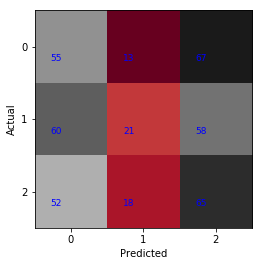

(0, 'ending paramaters', array([[ 0.22140552, -0.21565378,  0.2210637 ]], dtype=float32))
End:  22:34:32 04/02/18 UTC
Start:  22:34:32 04/02/18 UTC
Test date: 2015-04-10 (46626, 91) (11861, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.22140552, -0.21565378,  0.2210637 ]], dtype=float32))
Epoch 0 of 251 Loss: 0.84191 Test: 37.9% Val: 64.8% Rec: 0.49
Epoch 50 of 251 Loss: 0.60775 Test: 24.5% Val: 64.9% Rec: 0.50
Epoch 100 of 251 Loss: 0.47472 Test: 18.1% Val: 64.8% Rec: 0.50
Epoch 150 of 251 Loss: 0.38828 Test: 14.3% Val: 64.9% Rec: 0.50
Epoch 200 of 251 Loss: 0.33094 Test: 11.9% Val: 65.1% Rec: 0.50
Early stopping at Epoch  205: Best Epoch    5:
Epoch 205 of 251 Loss: 0.31816 Test: 11.4% Val: 65.1% Rec: 0.50
_Final_Epoch  205: Val_error: 65.1% 
             precision    recall  f1-score   support

          0       0.42      0.11      0.17       136
          1       0.39      0.31      0.35       138
          2       0.38      0.73      0.50       135

avg / total       0.40  

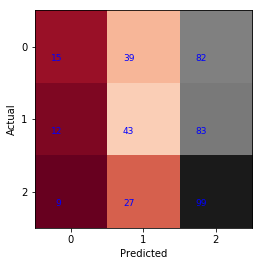

(0, 'ending paramaters', array([[ 0.22392665, -0.21950051,  0.22067857]], dtype=float32))
End:  22:35:49 04/02/18 UTC
Start:  22:35:49 04/02/18 UTC
Test date: 2015-05-08 (47035, 91) (11861, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.22392665, -0.21950051,  0.22067857]], dtype=float32))
Epoch 0 of 251 Loss: 0.81451 Test: 36.2% Val: 64.6% Rec: 0.51
Epoch 50 of 251 Loss: 0.59534 Test: 23.8% Val: 64.7% Rec: 0.52
Epoch 100 of 251 Loss: 0.47030 Test: 17.6% Val: 64.6% Rec: 0.52
Epoch 150 of 251 Loss: 0.38238 Test: 13.8% Val: 64.7% Rec: 0.52
Epoch 200 of 251 Loss: 0.32350 Test: 11.3% Val: 64.4% Rec: 0.52
Early stopping at Epoch  203: Best Epoch    3:
Epoch 203 of 251 Loss: 0.32112 Test: 11.3% Val: 64.5% Rec: 0.52
_Final_Epoch  203: Val_error: 64.5% 
             precision    recall  f1-score   support

          0       0.21      0.07      0.10       135
          1       0.36      0.53      0.43       139
          2       0.34      0.41      0.37       135

avg / total       0.31  

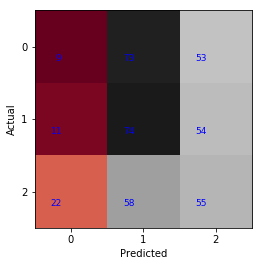

(0, 'ending paramaters', array([[ 0.22563551, -0.22190735,  0.22035614]], dtype=float32))
End:  22:37:08 04/02/18 UTC
Start:  22:37:08 04/02/18 UTC
Test date: 2015-06-08 (47444, 91) (11861, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.22563551, -0.22190735,  0.22035614]], dtype=float32))
Epoch 0 of 251 Loss: 0.80169 Test: 35.4% Val: 64.8% Rec: 0.51
Epoch 50 of 251 Loss: 0.58628 Test: 23.2% Val: 64.6% Rec: 0.51
Epoch 100 of 251 Loss: 0.46155 Test: 17.4% Val: 64.4% Rec: 0.51
Epoch 150 of 251 Loss: 0.37885 Test: 13.6% Val: 64.5% Rec: 0.51
Epoch 200 of 251 Loss: 0.32407 Test: 11.5% Val: 64.7% Rec: 0.51
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.32379 Test: 11.6% Val: 64.7% Rec: 0.51
_Final_Epoch  201: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.28      0.35      0.31       135
          1       0.53      0.24      0.33       139
          2       0.30      0.40      0.34       135

avg / total       0.37  

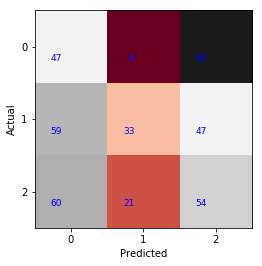

(0, 'ending paramaters', array([[ 0.22611311, -0.22285405,  0.22042152]], dtype=float32))
End:  22:38:23 04/02/18 UTC
Start:  22:38:23 04/02/18 UTC
Test date: 2015-07-07 (47444, 91) (12270, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.22611311, -0.22285405,  0.22042152]], dtype=float32))
Epoch 0 of 251 Loss: 0.79444 Test: 35.1% Val: 64.8% Rec: 0.00
Epoch 50 of 251 Loss: 0.58318 Test: 23.0% Val: 64.6% Rec: 0.50
Epoch 100 of 251 Loss: 0.45960 Test: 17.3% Val: 64.5% Rec: 0.50
Epoch 150 of 251 Loss: 0.37721 Test: 13.6% Val: 64.5% Rec: 0.50
Epoch 200 of 251 Loss: 0.32294 Test: 11.5% Val: 64.7% Rec: 0.50
Early stopping at Epoch  220: Best Epoch   20:
Epoch 220 of 251 Loss: 0.30327 Test: 10.6% Val: 64.6% Rec: 0.50
_Final_Epoch  220: Val_error: 64.6% 
             precision    recall  f1-score   support

          0       0.28      0.10      0.14       135
          1       0.39      0.64      0.48       139
          2       0.28      0.27      0.28       135

avg / total       0.32  

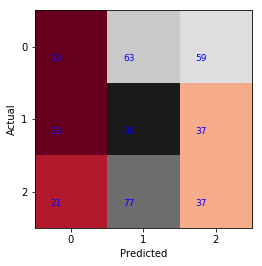

(0, 'ending paramaters', array([[ 0.24181192, -0.248665  ,  0.22020684]], dtype=float32))
End:  22:39:47 04/02/18 UTC
Start:  22:39:47 04/02/18 UTC
Test date: 2015-08-04 (47853, 91) (12270, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24181192, -0.248665  ,  0.22020684]], dtype=float32))
Epoch 0 of 251 Loss: 0.69859 Test: 29.5% Val: 64.8% Rec: 0.00
Epoch 50 of 251 Loss: 0.52925 Test: 20.4% Val: 64.4% Rec: 0.47
Epoch 100 of 251 Loss: 0.42456 Test: 15.8% Val: 64.4% Rec: 0.47
Epoch 150 of 251 Loss: 0.35129 Test: 12.6% Val: 64.5% Rec: 0.47
Epoch 200 of 251 Loss: 0.30399 Test: 10.6% Val: 64.5% Rec: 0.47
Early stopping at Epoch  206: Best Epoch    6:
Epoch 206 of 251 Loss: 0.29481 Test: 10.4% Val: 64.6% Rec: 0.47
_Final_Epoch  206: Val_error: 64.6% 
             precision    recall  f1-score   support

          0       0.33      0.16      0.22       135
          1       0.46      0.24      0.31       139
          2       0.35      0.70      0.46       135

avg / total       0.38  

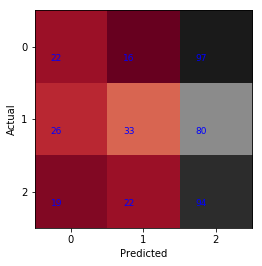

(0, 'ending paramaters', array([[ 0.24619421, -0.25734553,  0.22120135]], dtype=float32))
End:  22:41:07 04/02/18 UTC
Start:  22:41:07 04/02/18 UTC
Test date: 2015-09-01 (48262, 91) (12270, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24619421, -0.25734553,  0.22120135]], dtype=float32))
Epoch 0 of 251 Loss: 0.68559 Test: 28.8% Val: 64.4% Rec: 0.47
Epoch 50 of 251 Loss: 0.51798 Test: 20.1% Val: 64.6% Rec: 0.47
Epoch 100 of 251 Loss: 0.41781 Test: 15.6% Val: 64.6% Rec: 0.47
Epoch 150 of 251 Loss: 0.34787 Test: 12.5% Val: 64.4% Rec: 0.47
Epoch 200 of 251 Loss: 0.30013 Test: 10.6% Val: 64.6% Rec: 0.47
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30200 Test: 10.7% Val: 64.5% Rec: 0.47
_Final_Epoch  201: Val_error: 64.5% 
             precision    recall  f1-score   support

          0       0.52      0.08      0.14       135
          1       0.40      0.57      0.47       139
          2       0.32      0.45      0.37       135

avg / total       0.41  

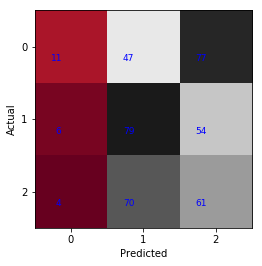

(0, 'ending paramaters', array([[ 0.24674538, -0.25880334,  0.22155201]], dtype=float32))
End:  22:42:26 04/02/18 UTC
Start:  22:42:26 04/02/18 UTC
Test date: 2015-09-30 (48671, 91) (12270, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24674538, -0.25880334,  0.22155201]], dtype=float32))
Epoch 0 of 251 Loss: 0.68924 Test: 28.7% Val: 64.4% Rec: 0.46
Epoch 50 of 251 Loss: 0.52927 Test: 20.5% Val: 64.7% Rec: 0.46
Epoch 100 of 251 Loss: 0.41929 Test: 15.2% Val: 64.6% Rec: 0.46
Epoch 150 of 251 Loss: 0.35491 Test: 12.8% Val: 64.6% Rec: 0.46
Epoch 200 of 251 Loss: 0.30682 Test: 11.0% Val: 64.8% Rec: 0.46
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30037 Test: 10.6% Val: 64.7% Rec: 0.46
_Final_Epoch  201: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.28      0.67      0.39       135
          1       0.20      0.04      0.07       139
          2       0.37      0.14      0.20       135

avg / total       0.28  

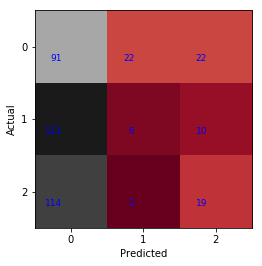

(0, 'ending paramaters', array([[ 0.24716154, -0.25977537,  0.22173941]], dtype=float32))
End:  22:43:44 04/02/18 UTC
Start:  22:43:44 04/02/18 UTC
Test date: 2015-10-28 (49080, 91) (12270, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24716154, -0.25977537,  0.22173941]], dtype=float32))
Epoch 0 of 251 Loss: 0.69819 Test: 28.8% Val: 64.7% Rec: 0.45
Epoch 50 of 251 Loss: 0.52565 Test: 20.2% Val: 64.7% Rec: 0.45
Epoch 100 of 251 Loss: 0.42080 Test: 15.5% Val: 64.8% Rec: 0.45
Epoch 150 of 251 Loss: 0.34837 Test: 12.7% Val: 64.8% Rec: 0.45
Epoch 200 of 251 Loss: 0.30280 Test: 10.7% Val: 64.8% Rec: 0.45
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30186 Test: 10.7% Val: 64.8% Rec: 0.45
_Final_Epoch  201: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.32      0.06      0.10       135
          1       0.36      0.86      0.51       139
          2       0.43      0.17      0.24       135

avg / total       0.37  

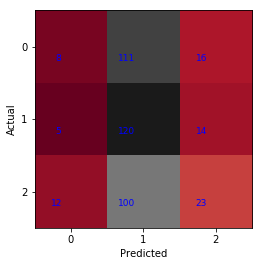

(0, 'ending paramaters', array([[ 0.24758019, -0.26053992,  0.22180673]], dtype=float32))
End:  22:45:03 04/02/18 UTC
Start:  22:45:03 04/02/18 UTC
Test date: 2015-11-25 (49080, 91) (12679, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24758019, -0.26053992,  0.22180673]], dtype=float32))
Epoch 0 of 251 Loss: 0.69200 Test: 28.5% Val: 64.6% Rec: 0.44
Epoch 50 of 251 Loss: 0.52308 Test: 20.1% Val: 64.7% Rec: 0.44
Epoch 100 of 251 Loss: 0.41925 Test: 15.4% Val: 64.8% Rec: 0.44
Epoch 150 of 251 Loss: 0.34737 Test: 12.7% Val: 64.8% Rec: 0.44
Epoch 200 of 251 Loss: 0.30202 Test: 10.7% Val: 64.8% Rec: 0.44
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30103 Test: 10.6% Val: 64.8% Rec: 0.44
_Final_Epoch  201: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.52      0.10      0.17       135
          1       0.34      0.37      0.35       139
          2       0.37      0.63      0.47       135

avg / total       0.41  

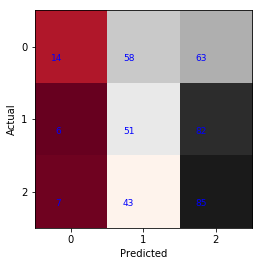

(0, 'ending paramaters', array([[ 0.24804336, -0.26137343,  0.22186151]], dtype=float32))
End:  22:46:23 04/02/18 UTC
Start:  22:46:23 04/02/18 UTC
Test date: 2015-12-24 (49489, 91) (12679, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24804336, -0.26137343,  0.22186151]], dtype=float32))
Epoch 0 of 251 Loss: 0.69244 Test: 28.8% Val: 64.5% Rec: 0.44
Epoch 50 of 251 Loss: 0.52118 Test: 19.9% Val: 65.1% Rec: 0.44
Epoch 100 of 251 Loss: 0.41455 Test: 15.1% Val: 65.1% Rec: 0.44
Epoch 150 of 251 Loss: 0.34844 Test: 12.5% Val: 65.0% Rec: 0.44
Epoch 200 of 251 Loss: 0.29766 Test: 10.4% Val: 64.9% Rec: 0.44
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30282 Test: 10.8% Val: 64.9% Rec: 0.44
_Final_Epoch  201: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.47      0.50      0.48       135
          1       0.32      0.18      0.23       139
          2       0.34      0.47      0.39       135

avg / total       0.37  

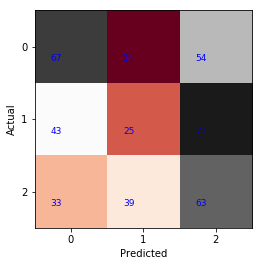

(0, 'ending paramaters', array([[ 0.24834843, -0.26238453,  0.22217536]], dtype=float32))
End:  22:47:41 04/02/18 UTC
Start:  22:47:41 04/02/18 UTC
Test date: 2016-01-26 (49898, 91) (12679, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24834843, -0.26238453,  0.22217536]], dtype=float32))
Epoch 0 of 251 Loss: 0.69429 Test: 29.0% Val: 64.4% Rec: 0.44
Epoch 50 of 251 Loss: 0.52193 Test: 20.1% Val: 64.7% Rec: 0.44
Epoch 100 of 251 Loss: 0.41873 Test: 15.4% Val: 64.7% Rec: 0.44
Epoch 150 of 251 Loss: 0.35010 Test: 12.6% Val: 64.8% Rec: 0.44
Epoch 200 of 251 Loss: 0.30322 Test: 10.9% Val: 64.7% Rec: 0.44
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.30026 Test: 10.5% Val: 64.7% Rec: 0.44
_Final_Epoch  201: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.35      0.43      0.39       136
          1       0.35      0.20      0.25       138
          2       0.33      0.39      0.36       135

avg / total       0.34  

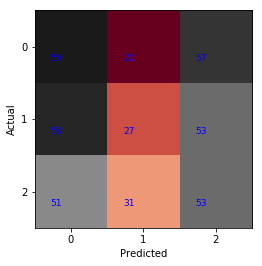

(0, 'ending paramaters', array([[ 0.24839042, -0.26334682,  0.22271888]], dtype=float32))
End:  22:49:00 04/02/18 UTC
Start:  22:49:00 04/02/18 UTC
Test date: 2016-02-24 (50307, 91) (12679, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24839042, -0.26334682,  0.22271888]], dtype=float32))
Epoch 0 of 251 Loss: 0.68784 Test: 28.7% Val: 64.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.51940 Test: 20.0% Val: 64.8% Rec: 0.00
Epoch 100 of 251 Loss: 0.41466 Test: 15.3% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.34550 Test: 12.2% Val: 64.6% Rec: 0.00
Epoch 200 of 251 Loss: 0.30182 Test: 10.7% Val: 64.7% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.30182 Test: 10.7% Val: 64.7% Rec: 0.00
_Final_Epoch  200: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.31      0.51      0.39       135
          1       0.41      0.37      0.39       139
          2       0.34      0.16      0.21       135

avg / total       0.35  

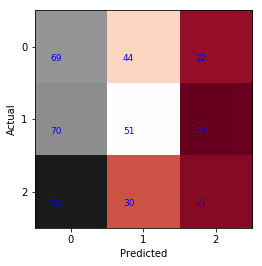

(0, 'ending paramaters', array([[ 0.24839042, -0.26334682,  0.22271888]], dtype=float32))
End:  22:50:22 04/02/18 UTC
Start:  22:50:22 04/02/18 UTC
Test date: 2016-03-23 (50716, 91) (12679, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.24839042, -0.26334682,  0.22271888]], dtype=float32))
Epoch 0 of 251 Loss: 0.68880 Test: 28.7% Val: 64.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.51791 Test: 19.9% Val: 64.7% Rec: 0.43
Epoch 100 of 251 Loss: 0.41372 Test: 15.3% Val: 64.8% Rec: 0.43
Epoch 150 of 251 Loss: 0.34291 Test: 12.3% Val: 65.0% Rec: 0.43
Epoch 200 of 251 Loss: 0.29978 Test: 10.5% Val: 64.9% Rec: 0.43
Early stopping at Epoch  203: Best Epoch    3:
Epoch 203 of 251 Loss: 0.29761 Test: 10.6% Val: 64.9% Rec: 0.43
_Final_Epoch  203: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.31      0.07      0.12       136
          1       0.37      0.88      0.52       138
          2       0.51      0.16      0.25       135

avg / total       0.40  

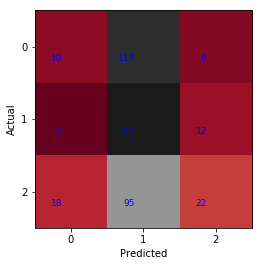

(0, 'ending paramaters', array([[ 0.25004452, -0.26691708,  0.2233685 ]], dtype=float32))
End:  22:51:47 04/02/18 UTC
Start:  22:51:47 04/02/18 UTC
Test date: 2016-04-21 (50716, 91) (13088, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.25004452, -0.26691708,  0.2233685 ]], dtype=float32))
Epoch 0 of 251 Loss: 0.67353 Test: 27.9% Val: 64.3% Rec: 0.42
Epoch 50 of 251 Loss: 0.51031 Test: 19.5% Val: 64.8% Rec: 0.42
Epoch 100 of 251 Loss: 0.40888 Test: 15.1% Val: 64.9% Rec: 0.42
Epoch 150 of 251 Loss: 0.33982 Test: 12.1% Val: 64.9% Rec: 0.42
Epoch 200 of 251 Loss: 0.29754 Test: 10.5% Val: 64.9% Rec: 0.42
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.29998 Test: 10.6% Val: 65.0% Rec: 0.42
_Final_Epoch  201: Val_error: 65.0% 
             precision    recall  f1-score   support

          0       0.36      0.03      0.05       135
          1       0.35      0.47      0.40       139
          2       0.29      0.46      0.36       135

avg / total       0.34  

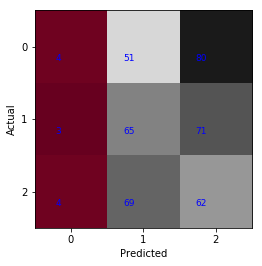

(0, 'ending paramaters', array([[ 0.25070176, -0.26803735,  0.22344097]], dtype=float32))
End:  22:53:10 04/02/18 UTC
Start:  22:53:10 04/02/18 UTC
Test date: 2016-05-19 (51125, 91) (13088, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.25070176, -0.26803735,  0.22344097]], dtype=float32))
Epoch 0 of 251 Loss: 0.67736 Test: 28.3% Val: 64.3% Rec: 0.42
Epoch 50 of 251 Loss: 0.51034 Test: 19.6% Val: 64.6% Rec: 0.42
Epoch 100 of 251 Loss: 0.40702 Test: 14.9% Val: 64.8% Rec: 0.42
Epoch 150 of 251 Loss: 0.34645 Test: 12.4% Val: 64.8% Rec: 0.42
Epoch 200 of 251 Loss: 0.29856 Test: 10.6% Val: 64.9% Rec: 0.42
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.29489 Test: 10.2% Val: 64.8% Rec: 0.42
_Final_Epoch  201: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.31      0.10      0.16       135
          1       0.39      0.52      0.44       139
          2       0.26      0.34      0.29       135

avg / total       0.32  

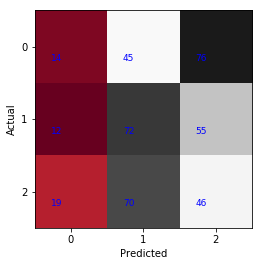

(0, 'ending paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
End:  22:54:33 04/02/18 UTC
Start:  22:54:33 04/02/18 UTC
Test date: 2016-06-17 (51534, 91) (13088, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
Epoch 0 of 251 Loss: 0.67456 Test: 28.2% Val: 64.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.51090 Test: 19.9% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.40810 Test: 15.1% Val: 65.0% Rec: 0.00
Epoch 150 of 251 Loss: 0.34442 Test: 12.3% Val: 65.2% Rec: 0.00
Epoch 200 of 251 Loss: 0.29582 Test: 10.3% Val: 65.2% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29582 Test: 10.3% Val: 65.2% Rec: 0.00
_Final_Epoch  200: Val_error: 65.2% 
             precision    recall  f1-score   support

          0       0.35      0.61      0.45       135
          1       0.42      0.24      0.30       139
          2       0.35      0.26      0.30       135

avg / total       0.38  

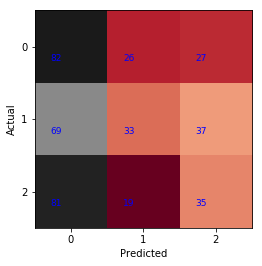

(0, 'ending paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
End:  22:55:55 04/02/18 UTC
Start:  22:55:55 04/02/18 UTC
Test date: 2016-07-18 (51943, 91) (13088, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
Epoch 0 of 251 Loss: 0.68187 Test: 28.8% Val: 64.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.50976 Test: 19.4% Val: 64.7% Rec: 0.00
Epoch 100 of 251 Loss: 0.40957 Test: 15.2% Val: 64.9% Rec: 0.00
Epoch 150 of 251 Loss: 0.34134 Test: 12.2% Val: 64.9% Rec: 0.00
Epoch 200 of 251 Loss: 0.29594 Test: 10.4% Val: 64.9% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29594 Test: 10.4% Val: 64.9% Rec: 0.00
_Final_Epoch  200: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.10      0.01      0.01       135
          1       0.37      0.53      0.44       139
          2       0.29      0.43      0.35       135

avg / total       0.25  

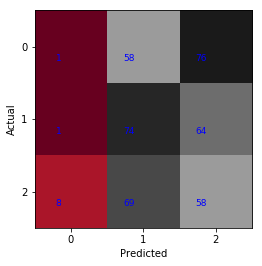

(0, 'ending paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
End:  22:57:17 04/02/18 UTC
Start:  22:57:17 04/02/18 UTC
Test date: 2016-08-15 (52352, 91) (13088, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
Epoch 0 of 251 Loss: 0.68136 Test: 28.4% Val: 64.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.50994 Test: 19.8% Val: 64.6% Rec: 0.00
Epoch 100 of 251 Loss: 0.40872 Test: 15.1% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.34599 Test: 12.5% Val: 64.8% Rec: 0.00
Epoch 200 of 251 Loss: 0.29868 Test: 10.5% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29868 Test: 10.5% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.25      0.12      0.16       135
          1       0.36      0.55      0.44       139
          2       0.43      0.43      0.43       135

avg / total       0.35  

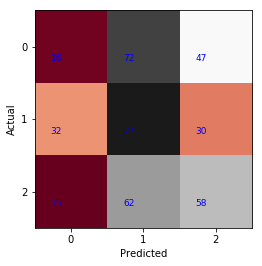

(0, 'ending paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
End:  22:58:42 04/02/18 UTC
Start:  22:58:42 04/02/18 UTC
Test date: 2016-09-13 (52352, 91) (13497, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
Epoch 0 of 251 Loss: 0.68136 Test: 28.4% Val: 64.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.50994 Test: 19.8% Val: 64.5% Rec: 0.00
Epoch 100 of 251 Loss: 0.40872 Test: 15.1% Val: 64.7% Rec: 0.00
Epoch 150 of 251 Loss: 0.34599 Test: 12.5% Val: 64.7% Rec: 0.00
Epoch 200 of 251 Loss: 0.29868 Test: 10.5% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29868 Test: 10.5% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.32      0.44      0.37       135
          1       0.41      0.37      0.39       139
          2       0.47      0.36      0.41       135

avg / total       0.40  

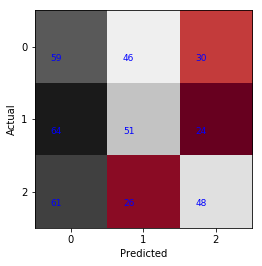

(0, 'ending paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
End:  23:00:11 04/02/18 UTC
Start:  23:00:11 04/02/18 UTC
Test date: 2016-10-11 (52761, 91) (13497, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2514367 , -0.2692708 ,  0.22349846]], dtype=float32))
Epoch 0 of 251 Loss: 0.68352 Test: 28.3% Val: 64.3% Rec: 0.00
Epoch 50 of 251 Loss: 0.50966 Test: 19.7% Val: 64.5% Rec: 0.41
Epoch 100 of 251 Loss: 0.40953 Test: 15.2% Val: 64.8% Rec: 0.41
Epoch 150 of 251 Loss: 0.34265 Test: 12.4% Val: 64.7% Rec: 0.41
Epoch 200 of 251 Loss: 0.29653 Test: 10.6% Val: 64.7% Rec: 0.41
Early stopping at Epoch  220: Best Epoch   20:
Epoch 220 of 251 Loss: 0.28527 Test: 10.1% Val: 64.7% Rec: 0.41
_Final_Epoch  220: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.35      0.29      0.32       137
          1       0.37      0.45      0.41       136
          2       0.33      0.32      0.33       136

avg / total       0.35  

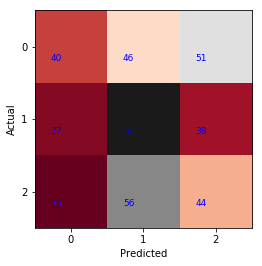

(0, 'ending paramaters', array([[ 0.2665874 , -0.29702884,  0.22587556]], dtype=float32))
End:  23:01:43 04/02/18 UTC
Start:  23:01:43 04/02/18 UTC
Test date: 2016-11-08 (53170, 91) (13497, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2665874 , -0.29702884,  0.22587556]], dtype=float32))
Epoch 0 of 251 Loss: 0.59725 Test: 24.0% Val: 64.2% Rec: 0.41
Epoch 50 of 251 Loss: 0.46400 Test: 17.5% Val: 64.4% Rec: 0.41
Epoch 100 of 251 Loss: 0.38038 Test: 13.9% Val: 64.7% Rec: 0.41
Epoch 150 of 251 Loss: 0.32474 Test: 11.6% Val: 64.6% Rec: 0.41
Epoch 200 of 251 Loss: 0.28464 Test: 10.0% Val: 64.5% Rec: 0.41
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.28595 Test: 10.1% Val: 64.5% Rec: 0.41
_Final_Epoch  201: Val_error: 64.5% 
             precision    recall  f1-score   support

          0       0.16      0.14      0.15       135
          1       0.41      0.40      0.40       139
          2       0.27      0.31      0.29       135

avg / total       0.28  

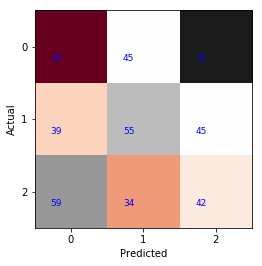

(0, 'ending paramaters', array([[ 0.26773092, -0.298416  ,  0.22561665]], dtype=float32))
End:  23:03:09 04/02/18 UTC
Start:  23:03:09 04/02/18 UTC
Test date: 2016-12-07 (53579, 91) (13497, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.26773092, -0.298416  ,  0.22561665]], dtype=float32))
Epoch 0 of 251 Loss: 0.60586 Test: 24.2% Val: 64.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.46704 Test: 17.7% Val: 64.8% Rec: 0.00
Epoch 100 of 251 Loss: 0.38086 Test: 14.0% Val: 64.9% Rec: 0.00
Epoch 150 of 251 Loss: 0.32974 Test: 12.0% Val: 64.8% Rec: 0.00
Epoch 200 of 251 Loss: 0.28679 Test: 10.3% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.28679 Test: 10.3% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.16      0.04      0.07       135
          1       0.37      0.50      0.43       139
          2       0.42      0.57      0.49       135

avg / total       0.32  

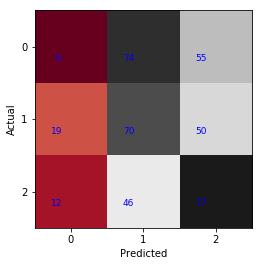

(0, 'ending paramaters', array([[ 0.26773092, -0.298416  ,  0.22561665]], dtype=float32))
End:  23:04:35 04/02/18 UTC
Start:  23:04:35 04/02/18 UTC
Test date: 2017-01-06 (53988, 91) (13497, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.26773092, -0.298416  ,  0.22561665]], dtype=float32))
Epoch 0 of 251 Loss: 0.61135 Test: 24.4% Val: 64.5% Rec: 0.40
Epoch 50 of 251 Loss: 0.46723 Test: 17.5% Val: 64.7% Rec: 0.40
Epoch 100 of 251 Loss: 0.38492 Test: 14.1% Val: 64.9% Rec: 0.40
Epoch 150 of 251 Loss: 0.32594 Test: 11.6% Val: 64.8% Rec: 0.40
Epoch 200 of 251 Loss: 0.28591 Test: 10.2% Val: 64.8% Rec: 0.40
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.28761 Test: 10.2% Val: 64.7% Rec: 0.40
_Final_Epoch  201: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.33      0.32      0.32       135
          1       0.36      0.23      0.28       139
          2       0.39      0.54      0.45       135

avg / total       0.36  

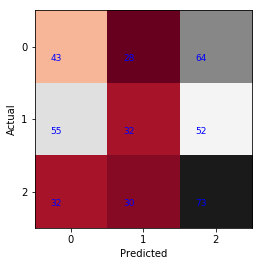

(0, 'ending paramaters', array([[ 0.2687379 , -0.2989952 ,  0.22493474]], dtype=float32))
End:  23:06:01 04/02/18 UTC
Start:  23:06:01 04/02/18 UTC
Test date: 2017-02-06 (53988, 91) (13906, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.2687379 , -0.2989952 ,  0.22493474]], dtype=float32))
Epoch 0 of 251 Loss: 0.60597 Test: 24.2% Val: 64.5% Rec: 0.41
Epoch 50 of 251 Loss: 0.46516 Test: 17.4% Val: 64.7% Rec: 0.41
Epoch 100 of 251 Loss: 0.38370 Test: 14.1% Val: 64.8% Rec: 0.41
Epoch 150 of 251 Loss: 0.32501 Test: 11.5% Val: 64.7% Rec: 0.41
Epoch 200 of 251 Loss: 0.28551 Test: 10.1% Val: 64.7% Rec: 0.41
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.28713 Test: 10.2% Val: 64.7% Rec: 0.41
_Final_Epoch  201: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.49      0.55      0.52       135
          1       0.41      0.43      0.42       138
          2       0.33      0.26      0.29       136

avg / total       0.41  

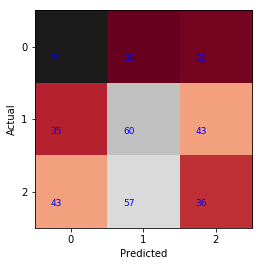

(0, 'ending paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
End:  23:07:27 04/02/18 UTC
Start:  23:07:27 04/02/18 UTC
Test date: 2017-03-07 (54397, 91) (13906, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
Epoch 0 of 251 Loss: 0.61374 Test: 24.7% Val: 64.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.46759 Test: 17.7% Val: 65.0% Rec: 0.00
Epoch 100 of 251 Loss: 0.38393 Test: 14.2% Val: 64.5% Rec: 0.00
Epoch 150 of 251 Loss: 0.32792 Test: 11.8% Val: 64.5% Rec: 0.00
Epoch 200 of 251 Loss: 0.28604 Test: 10.1% Val: 64.6% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.28604 Test: 10.1% Val: 64.6% Rec: 0.00
_Final_Epoch  200: Val_error: 64.6% 
             precision    recall  f1-score   support

          0       0.29      0.44      0.35       136
          1       0.34      0.13      0.19       138
          2       0.30      0.33      0.31       135

avg / total       0.31  

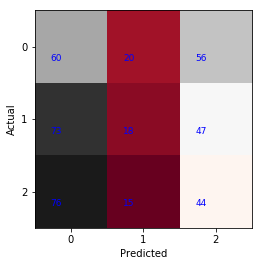

(0, 'ending paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
End:  23:08:55 04/02/18 UTC
Start:  23:08:55 04/02/18 UTC
Test date: 2017-04-04 (54806, 91) (13906, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
Epoch 0 of 251 Loss: 0.62103 Test: 25.0% Val: 64.7% Rec: 0.00
Epoch 50 of 251 Loss: 0.47567 Test: 18.4% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.38859 Test: 14.4% Val: 64.6% Rec: 0.00
Epoch 150 of 251 Loss: 0.33244 Test: 12.0% Val: 64.7% Rec: 0.00
Epoch 200 of 251 Loss: 0.29269 Test: 10.5% Val: 65.0% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29269 Test: 10.5% Val: 65.0% Rec: 0.00
_Final_Epoch  200: Val_error: 65.0% 
             precision    recall  f1-score   support

          0       0.41      0.24      0.30       135
          1       0.42      0.37      0.39       139
          2       0.39      0.60      0.47       135

avg / total       0.40  

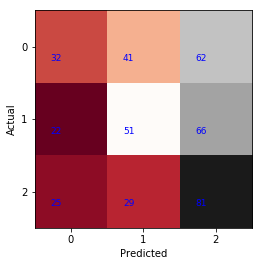

(0, 'ending paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
End:  23:10:24 04/02/18 UTC
Start:  23:10:24 04/02/18 UTC
Test date: 2017-05-02 (55215, 91) (13906, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.26970214, -0.29973447,  0.22439185]], dtype=float32))
Epoch 0 of 251 Loss: 0.63372 Test: 25.2% Val: 64.6% Rec: 0.00
Epoch 50 of 251 Loss: 0.48210 Test: 18.3% Val: 64.6% Rec: 0.39
Epoch 100 of 251 Loss: 0.39206 Test: 14.4% Val: 64.5% Rec: 0.39
Epoch 150 of 251 Loss: 0.33515 Test: 12.2% Val: 64.6% Rec: 0.39
Epoch 200 of 251 Loss: 0.29604 Test: 10.6% Val: 64.6% Rec: 0.39
Early stopping at Epoch  202: Best Epoch    2:
Epoch 202 of 251 Loss: 0.29624 Test: 10.6% Val: 64.7% Rec: 0.39
_Final_Epoch  202: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.48      0.33      0.39       135
          1       0.43      0.12      0.18       139
          2       0.36      0.73      0.48       135

avg / total       0.42  

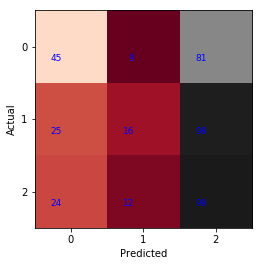

(0, 'ending paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
End:  23:11:54 04/02/18 UTC
Start:  23:11:54 04/02/18 UTC
Test date: 2017-05-31 (55624, 91) (13906, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
Epoch 0 of 251 Loss: 0.62842 Test: 25.2% Val: 64.6% Rec: 0.00
Epoch 50 of 251 Loss: 0.47613 Test: 18.1% Val: 64.7% Rec: 0.00
Epoch 100 of 251 Loss: 0.39670 Test: 14.8% Val: 64.5% Rec: 0.00
Epoch 150 of 251 Loss: 0.33802 Test: 12.3% Val: 64.8% Rec: 0.00
Epoch 200 of 251 Loss: 0.29787 Test: 10.7% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29787 Test: 10.7% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.37      0.23      0.28       135
          1       0.39      0.48      0.43       139
          2       0.39      0.45      0.42       135

avg / total       0.39  

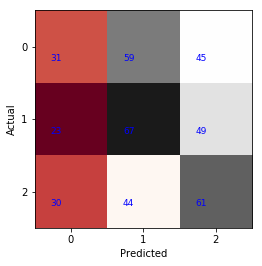

(0, 'ending paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
End:  23:13:23 04/02/18 UTC
Start:  23:13:23 04/02/18 UTC
Test date: 2017-06-28 (55624, 91) (14315, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
Epoch 0 of 251 Loss: 0.62842 Test: 25.2% Val: 64.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.47613 Test: 18.1% Val: 64.7% Rec: 0.00
Epoch 100 of 251 Loss: 0.39670 Test: 14.8% Val: 64.6% Rec: 0.00
Epoch 150 of 251 Loss: 0.33802 Test: 12.3% Val: 64.8% Rec: 0.00
Epoch 200 of 251 Loss: 0.29787 Test: 10.7% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29787 Test: 10.7% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.24      0.30      0.27       135
          1       0.40      0.38      0.39       138
          2       0.33      0.26      0.29       136

avg / total       0.33  

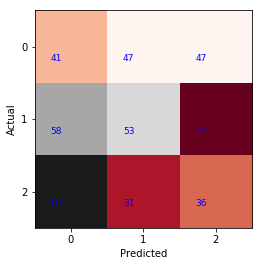

(0, 'ending paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
End:  23:14:54 04/02/18 UTC
Start:  23:14:54 04/02/18 UTC
Test date: 2017-07-27 (56033, 91) (14315, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27121943, -0.3010305 ,  0.22360861]], dtype=float32))
Epoch 0 of 251 Loss: 0.63719 Test: 25.2% Val: 64.3% Rec: 0.39
Epoch 50 of 251 Loss: 0.48216 Test: 18.4% Val: 64.6% Rec: 0.39
Epoch 100 of 251 Loss: 0.39802 Test: 14.8% Val: 64.7% Rec: 0.39
Epoch 150 of 251 Loss: 0.33922 Test: 12.3% Val: 64.8% Rec: 0.39
Epoch 200 of 251 Loss: 0.30404 Test: 11.1% Val: 64.8% Rec: 0.39
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.29640 Test: 10.7% Val: 64.8% Rec: 0.39
_Final_Epoch  201: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.39      0.16      0.23       135
          1       0.30      0.22      0.26       139
          2       0.34      0.62      0.44       135

avg / total       0.34  

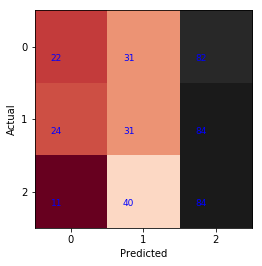

(0, 'ending paramaters', array([[ 0.27179724, -0.301283  ,  0.22319132]], dtype=float32))
End:  23:16:24 04/02/18 UTC
Start:  23:16:24 04/02/18 UTC
Test date: 2017-08-24 (56442, 91) (14315, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27179724, -0.301283  ,  0.22319132]], dtype=float32))
Epoch 0 of 251 Loss: 0.64108 Test: 25.4% Val: 64.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.48333 Test: 18.4% Val: 64.8% Rec: 0.39
Epoch 100 of 251 Loss: 0.39939 Test: 14.9% Val: 64.8% Rec: 0.39
Epoch 150 of 251 Loss: 0.34195 Test: 12.5% Val: 64.9% Rec: 0.39
Epoch 200 of 251 Loss: 0.29996 Test: 10.6% Val: 65.0% Rec: 0.39
Early stopping at Epoch  209: Best Epoch    9:
Epoch 209 of 251 Loss: 0.29311 Test: 10.6% Val: 65.1% Rec: 0.39
_Final_Epoch  209: Val_error: 65.1% 
             precision    recall  f1-score   support

          0       0.21      0.06      0.09       135
          1       0.35      0.17      0.23       139
          2       0.36      0.80      0.50       135

avg / total       0.30  

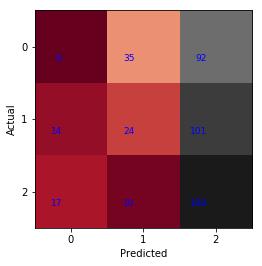

(0, 'ending paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
End:  23:17:58 04/02/18 UTC
Start:  23:17:58 04/02/18 UTC
Test date: 2017-09-22 (56851, 91) (14315, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
Epoch 0 of 251 Loss: 0.60786 Test: 24.1% Val: 64.7% Rec: 0.00
Epoch 50 of 251 Loss: 0.46830 Test: 17.9% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.38946 Test: 14.4% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.33435 Test: 12.2% Val: 64.9% Rec: 0.00
Epoch 200 of 251 Loss: 0.29656 Test: 10.6% Val: 64.9% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29656 Test: 10.6% Val: 64.9% Rec: 0.00
_Final_Epoch  200: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.36      0.50      0.42       135
          1       0.42      0.13      0.20       139
          2       0.37      0.48      0.42       135

avg / total       0.38  

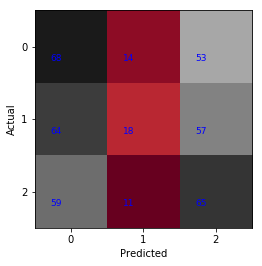

(0, 'ending paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
End:  23:19:31 04/02/18 UTC
Start:  23:19:31 04/02/18 UTC
Test date: 2017-10-20 (57260, 91) (14315, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
Epoch 0 of 251 Loss: 0.61332 Test: 24.2% Val: 64.8% Rec: 0.00
Epoch 50 of 251 Loss: 0.47185 Test: 17.9% Val: 65.0% Rec: 0.00
Epoch 100 of 251 Loss: 0.38988 Test: 14.5% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.33742 Test: 12.2% Val: 64.7% Rec: 0.00
Epoch 200 of 251 Loss: 0.29921 Test: 10.9% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29921 Test: 10.9% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.39      0.18      0.24       135
          1       0.36      0.53      0.43       139
          2       0.31      0.33      0.32       135

avg / total       0.35  

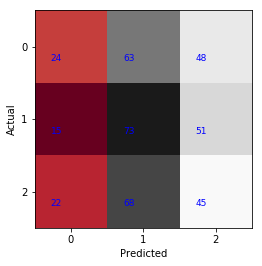

(0, 'ending paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
End:  23:21:04 04/02/18 UTC
Start:  23:21:04 04/02/18 UTC
Test date: 2017-11-20 (57260, 91) (14724, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
Epoch 0 of 251 Loss: 0.61332 Test: 24.2% Val: 64.8% Rec: 0.00
Epoch 50 of 251 Loss: 0.47185 Test: 17.9% Val: 65.0% Rec: 0.00
Epoch 100 of 251 Loss: 0.38988 Test: 14.5% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.33742 Test: 12.2% Val: 64.7% Rec: 0.00
Epoch 200 of 251 Loss: 0.29921 Test: 10.9% Val: 64.8% Rec: 0.00
Early stopping at Epoch  200: Best Epoch    0:
Epoch 200 of 251 Loss: 0.29921 Test: 10.9% Val: 64.8% Rec: 0.00
_Final_Epoch  200: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.29      0.19      0.23       135
          1       0.34      0.24      0.28       139
          2       0.38      0.62      0.47       135

avg / total       0.34  

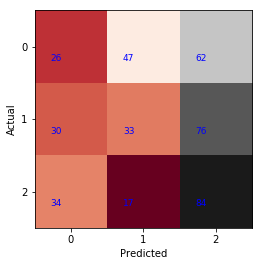

(0, 'ending paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
End:  23:22:37 04/02/18 UTC
Start:  23:22:37 04/02/18 UTC
Test date: 2017-12-19 (57669, 91) (14724, 91) (409, 91)
(0, 'beginning paramaters', array([[ 0.27572545, -0.3018117 ,  0.21952453]], dtype=float32))
Epoch 0 of 251 Loss: 0.61985 Test: 24.7% Val: 64.7% Rec: 0.39
Epoch 50 of 251 Loss: 0.47218 Test: 17.9% Val: 64.8% Rec: 0.39
Epoch 100 of 251 Loss: 0.39287 Test: 14.5% Val: 64.7% Rec: 0.39
Epoch 150 of 251 Loss: 0.33506 Test: 12.1% Val: 64.9% Rec: 0.39
Epoch 200 of 251 Loss: 0.29627 Test: 10.5% Val: 65.0% Rec: 0.39
Early stopping at Epoch  201: Best Epoch    1:
Epoch 201 of 251 Loss: 0.29591 Test: 10.7% Val: 64.9% Rec: 0.39
_Final_Epoch  201: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.36      0.41      0.38       135
          1       0.39      0.41      0.40       139
          2       0.45      0.38      0.41       135

avg / total       0.40  

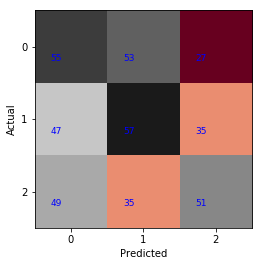

(0, 'ending paramaters', array([[ 0.27608734, -0.30209526,  0.21934634]], dtype=float32))
End:  23:24:09 04/02/18 UTC


In [18]:
# First, identify train and validation sets (80% of all data for the two)
# Train the initial model using these data sets
# Then, for the sequence of test dates,
#   1- evaluate the current model, 
#   2- expand train/validate set to include the last test date,
#   3- retrain the model using the new train/validate sets 

dates = dflong['Date'].drop_duplicates()
dates = sorted(dates)
trval_dates = sorted(dates[ : int(len(dates) * .80)]) # Initial training plus validation dates
test_dates = sorted(set(dates) - set(trval_dates)) # All test dates
 
new = 1 # Output file: create for first date, then keep on appending

for testdate in test_dates: 
    tf.set_random_seed(30)
    random.seed(30) 
    np.random.seed(30)
    
    print "Start: ", (time.strftime('%X %x %Z'))
    create_datasets(trval_dates, testdate)
    print "Test date:", testdate, train_data.shape, validation_data.shape, test_data.shape

    num_epochs = 251
    m = train_data.shape[0] # number of training examples
    n_x = train_data.shape[1] # number of features 
    n_y = train_labels.shape[1] # number of outputs: 0/1/2 for Down/Mid/Up

    minibatch_size = 128
    l_rate = 0.00001
    n_ll = [104]
    activation = 'leaky_relu'
    n_l = n_ll[0] # number of nodes in the (first) hidden layer

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step, which we'll write once we define the graph structure.
    train_data_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_x))
    train_labels_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_y))

    # For the test data, we'll just hold the entire dataset in one constant node.
    validation_data_node = tf.cast(tf.constant(validation_data), tf.float32)
    test_data_node = tf.cast(tf.constant(test_data), tf.float32)
    
    init_xavier = tf.contrib.layers.xavier_initializer()
    init_zeros = tf.zeros_initializer()
    
    fc1_weights = tf.Variable(init_xavier([n_x, n_l])) 
    fc1_biases = tf.Variable(init_zeros([n_l]))
    fc2_weights = tf.Variable(init_xavier([n_l, n_y]))
    fc2_biases = tf.Variable(init_zeros([n_y]))

    # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, activation, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels = train_labels_node, logits=logits))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                    tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 0.0001 * regularizers

    #optimizer = tf.train.AdamOptimizer(l_rate, 0.9).minimize(loss) 
    optimizer = tf.train.AdamOptimizer(l_rate).minimize(loss) 

    # Predictions for the minibatch and test set.
    train_prediction = tf.nn.softmax(logits)
    validation_prediction = tf.nn.softmax(model(validation_data_node, activation))
    test_prediction = tf.nn.softmax(model(test_data_node, activation))

    # Create a new interactive session that we'll use in
    # subsequent code cells.
    sess = tf.InteractiveSession()

    # Use our newly created session as the default for 
    # subsequent operations.
    sess.as_default()
    saver = tf.train.Saver()
    # Initialize all the variables we defined above.
    #tf.global_variables_initializer().run()
    if new == 0:                               # After the first test date, use the best model                                    
        saver.restore(sess,'/tmp/model.ckpt')  # from the previous date to get the training started  
    else:
        tf.global_variables_initializer().run()
    # Early stopping implemented from Goodfellow et al (p270)
    # Note: my version monitors test set accuracy
    # as opposed to validation set error in the book
    # e_ denotes a variable used in early stopping algorithm

    e_i = 0    
    e_j = 0
    e_rstar = 0  # highest recall for 2
    e_istar = e_i
    e_p = 200  # patience: set to 250 in round 1, 20 in round 2
    e_n = 1    # number of steps between evaluations

    print (new, 'beginning paramaters', fc2_weights.eval()[0:1,])
    num_minibatches = int(train_data.shape[0] / minibatch_size)  
    
    for epoch in range(num_epochs):
        b_list = list(range(0, num_minibatches))
        random.shuffle(b_list)
        epoch_error = 0
        epoch_loss = 0

        for i in b_list:   
            batch_data = train_data[i:i+minibatch_size, :]
            batch_labels = train_labels[i:i+minibatch_size]
            feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
            # Run the graph and fetch some of the nodes.
            _, l, predictions = sess.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            error = error_rate(predictions, batch_labels)
            epoch_error += error
            epoch_loss += l

        if epoch % e_n == 0:
            epoch_error /= num_minibatches
            epoch_loss /= num_minibatches
            e_v = error_rate(validation_prediction.eval(), validation_labels)
            y_true = np.argmax(validation_labels,1)
            y_pred = np.argmax(validation_prediction.eval(),1)
            f1_2 = f1_score(y_true, y_pred, average = None)[2]
            recall_2 = recall_score(y_true, y_pred, average = None)[2]
            precision_2 = precision_score(y_true, y_pred, average = None)[2]

            # Early stopping test  
            e_i += e_n
            if ((precision_2 >= 0.35) & (e_rstar < recall_2)):
                e_j = 0
                e_istar = e_i
                e_rstar = recall_2
                save_path = saver.save(sess, "/tmp/model.ckpt") # Current best model
            else:
                e_j += 1
            if ((epoch == 0) | (epoch % 50 == 0)):
                print('Epoch %d of %d Loss: %.5f Test: %.1f%% Val: %.1f%% Rec: %.2f' %
                      (epoch, num_epochs, epoch_loss, epoch_error, e_v, e_rstar))      
                
            if e_j > e_p:
                print ("Early stopping at Epoch %4i: Best Epoch %4i:" % 
                       (epoch, e_istar))
                print('Epoch %d of %d Loss: %.5f Test: %.1f%% Val: %.1f%% Rec: %.2f' %
                      (epoch, num_epochs, epoch_loss, epoch_error, e_v, e_rstar))
                break

    saver.restore(sess, "/tmp/model.ckpt") 
    val_error = error_rate(validation_prediction.eval(), validation_labels)
    print ("_Final_Epoch %4i: Val_error: %.1f%% "  % (epoch,e_v))
    
    # Model performance
    y_true = np.argmax(test_labels,1)
    y_pred = np.argmax(test_prediction.eval(),1)

    show_results(y_true, y_pred)
    
    # Model predicted probabilities and outcome
    columns = ['pr_0','pr_1','pr_2']
    pred_df = pd.DataFrame(test_prediction.eval(),columns=columns)
    pred_df['Y_pred'] = np.argmax(test_prediction.eval(),1)
    pred_df.reset_index(drop=True, inplace=True)  

    # Output data set includes this month's and next month's returns
    inp_data = dflong[dflong['Date'] == testdate][id_cols + other_cols + y_col]
    inp_data.reset_index(drop=True, inplace=True)

    out_df = pd.concat([inp_data, pred_df], axis=1) 

    # Benchmark predictions

    # Momentum and reversal
    # Momentum: predict 2 for this month's 2
    # Reversal: predict 0 for this month's 2
    # Use 33% and 67% cutoffs to obtain three-level prediction
    out_df['Q33'] = out_df.groupby(['Date'])['R'].transform(lambda x: x.quantile(.33))
    out_df['Q67'] = out_df.groupby(['Date'])['R'].transform(lambda x: x.quantile(.67))
    out_df['Y_mom'] = 1 # default
    out_df['Y_mom'][out_df['R'] >= out_df['Q67']] = 2
    out_df['Y_mom'][out_df['R'] <= out_df['Q33']] = 0

    out_df['Y_rev'] = 1 # default
    out_df['Y_rev'][out_df['R'] >= out_df['Q67']] = 0
    out_df['Y_rev'][out_df['R'] <= out_df['Q33']] = 2
    out_df.drop(['Q33','Q67'], axis = 1, inplace=True)

    # Randomly select Down/Mid/Up or Down/Up
    out_df['Y_rand3'] = np.random.randint(3, size=out_df.shape[0]) # Down/Mid/Up
    # Down/Up only: 0s remain 0s, 1s become 2s

    if new == 1:
        out_df.to_csv('SP500_Results_V4.CSV', index = False, float_format='%.4f')
        new = 0
    else:
        out_df.to_csv('SP500_Results_V4.CSV', index = False, mode = 'a', header = False, float_format='%.4f')
    
    trval_dates.append(testdate)
    print (new, 'ending paramaters', fc2_weights.eval()[0:1,])
    print "End: ", (time.strftime('%X %x %Z'))
    tf.reset_default_graph()

## Functions


In [13]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')   
    one_hot_matrix = tf.one_hot(labels, C,  axis = 1) #axis = 0) 
        # each row is one observation, thus axis = 1
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix) 
    sess.close()
    
    return one_hot

In [14]:
def create_datasets(trval_dates, testdate):
    global train_data, train_labels, validation_data, validation_labels, test_data, test_labels
    train_dates = sorted(trval_dates[ : int(len(trval_dates) * .80)])
    validation_dates = sorted(set(trval_dates) - set(train_dates))   
    
    # Not all data items in the main dataset are used as features
    # Select the features here
    included_features = cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols

    train_data = dflong[dflong['Date'].isin(train_dates)][included_features].as_matrix()
    validation_data = dflong[dflong['Date'].isin(validation_dates)][included_features].as_matrix()
    test_data = dflong[dflong['Date'] == testdate][included_features].as_matrix()

    # Convert Y from 0/1/2 to one-hot format
    train_labels = one_hot_matrix(dflong[dflong['Date'].isin(train_dates)]['Y'].as_matrix(), 3) 
    validation_labels = one_hot_matrix(dflong[dflong['Date'].isin(validation_dates)]['Y'].as_matrix(), 3)
    test_labels = one_hot_matrix(dflong[dflong['Date'] == testdate]['Y'].as_matrix(), 3) 
    return

In [15]:
def model(data, activation, train=False):
    hidden = tf.nn.leaky_relu(tf.matmul(data, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

In [16]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    return error

In [17]:
def show_results (y_true, y_pred):

    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    
    confusions = np.zeros([3, 3], np.float32)
    bundled = zip(y_true, y_pred)
    for actual, predicted in bundled:
        confusions[actual, predicted] += 1

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid(False)
    plt.xticks(np.arange(3))
    plt.yticks(np.arange(3))
    plt.imshow(confusions, cmap=plt.cm.RdGy, interpolation='nearest')

    for i, cas in enumerate(confusions):
        for j, count in enumerate(cas):
            if count >= 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=9, color='blue')
    plt.show() 